# RFM - Recency, Frequency, Monetary Analysis

In this Section we are going to use RFM analysis to understand customer behaviour. We can idntify the category under which a customer falls under by making use of the transaction data.
By Recency, Frequency and Monetary Analysis helps us get insight on the cutomers and revenue:
1. Discover market trends and Patterns
2. Finding the customers at risk
3. Identifying ways to retain customers
4. Increase the revenue by identifying the target customers.

In this approach we using RFM analysis in combination with k-means clustering prediction algorithm 

In [1]:
# importing pandas for dataframe
import pandas as pd
# importing numpy for numeric computing
import numpy as np
# import time and warnings
import time, warnings
# import datetime
import datetime as dt

#modules for predictive models
import sklearn.cluster as cluster
# import kmeans
from sklearn.cluster import KMeans
# import PCA
from sklearn.decomposition import PCA
# importing Gaussian mixture model
from sklearn.mixture import GMM

from sklearn.metrics import silhouette_samples, silhouette_score

#visualizations
import matplotlib.pyplot as plt
# import scatter matrix for visualization
from pandas.plotting import scatter_matrix
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

**Data preparation**

In [2]:
#load the dataset
product_df = pd.read_excel("Online Retail.xlsx")
product_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
# Fetching United Kingdom retail store transactions
Online_retail_uk = product_df[product_df['Country']=='United Kingdom']
# check the shape
Online_retail_uk.shape

(495478, 8)

In [4]:
# removing canceled orders
Online_retail_uk = Online_retail_uk[Online_retail_uk['Quantity']>0]
Online_retail_uk.shape

(486286, 8)

In [5]:
# Droping all rows with not applicable Customer ID
Online_retail_uk.dropna(subset=['CustomerID'],how='all',inplace=True)
Online_retail_uk.shape

(354345, 8)

In [6]:
# Fetching one year dataset which makes it convinient to run RFM analysis
Online_retail_uk = Online_retail_uk[Online_retail_uk['InvoiceDate']>= "2010-12-09"]
Online_retail_uk.shape

(342478, 8)

In [7]:
print("Summary..")
# Computing the unique values of each attribute
print("Total Number of transactions: ", Online_retail_uk['InvoiceNo'].nunique())
print("TotalNumber of products bought: ",Online_retail_uk['StockCode'].nunique())
print("Total Number of customers:", Online_retail_uk['CustomerID'].nunique() )
print("Total Percentage of customers NA: ", round(Online_retail_uk['CustomerID'].isnull().sum() * 100 / len(product_df),2),"%" )

Summary..
Total Number of transactions:  16017
TotalNumber of products bought:  3611
Total Number of customers: 3863
Total Percentage of customers NA:  0.0 %


RFM Analysis is a customer segmentation analysis. It involves calculating 
1. Recency: Days since last purchase 
2. Frequency: Total number of purchases
3. Monetary: Total amount spent by the customer   
    
Studying this helps us identify the target cutsomers who respond to the promotional adds and the products that they might potentially buy 

**RECENCY** : total number of days since the customer made the last purchase. This is calculated w.r.t to the last day of the year that we have considered for RFM analysis.

In [9]:
# last transaction date available in our dataset
Online_retail_uk['InvoiceDate'].max()

Timestamp('2011-12-09 12:49:00')

In [10]:
last_date = dt.date(2011,12,9)
print(last_date)

2011-12-09


In [11]:
# Creating a new feature with just invoice date for the ease of computation
Online_retail_uk['date'] = Online_retail_uk['InvoiceDate'].dt.date

In [12]:
# Displaying the first five rows
Online_retail_uk.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,date
19632,537879,22114,HOT WATER BOTTLE TEA AND SYMPATHY,12,2010-12-09 08:34:00,3.95,14243.0,United Kingdom,2010-12-09
19633,537879,22835,HOT WATER BOTTLE I AM SO POORLY,8,2010-12-09 08:34:00,4.65,14243.0,United Kingdom,2010-12-09
19634,537879,85150,LADIES & GENTLEMEN METAL SIGN,6,2010-12-09 08:34:00,2.55,14243.0,United Kingdom,2010-12-09
19635,537879,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,4,2010-12-09 08:34:00,7.95,14243.0,United Kingdom,2010-12-09
19636,537879,21524,DOORMAT SPOTTY HOME SWEET HOME,2,2010-12-09 08:34:00,7.95,14243.0,United Kingdom,2010-12-09


In [13]:
# group by customers and check last date of purshace
recency_ds = Online_retail_uk.groupby(by='CustomerID', as_index=False)['date'].max()
# Fetching last purchase date of each cutsomer
recency_ds.columns = ['CustomerID','LastPurshaceDate']
recency_ds.head()

,CustomerID,LastPurshaceDate
0,12346.0,2011-01-18
1,12747.0,2011-12-07
2,12748.0,2011-12-09
3,12749.0,2011-12-06
4,12820.0,2011-12-06


In [14]:
# calculate recency
recency_ds['Recency'] = recency_ds['LastPurshaceDate'].apply(lambda x: (last_date - x).days)

In [15]:
recency_ds.head()

,CustomerID,LastPurshaceDate,Recency
0,12346.0,2011-01-18,325
1,12747.0,2011-12-07,2
2,12748.0,2011-12-09,0
3,12749.0,2011-12-06,3
4,12820.0,2011-12-06,3


In [16]:
# remove LastPurchaseDate column as it's unneccesary
recency_ds.drop('LastPurshaceDate',axis=1,inplace=True)

** Frequency: ** The number of purchases made by the customer. we look into the number of invoices in the trasaction dataset.

In [17]:
#  Removing all duplicates in the dataset to get one record per each transaction of the customer.
online_retail_uk2 = Online_retail_uk
online_retail_uk2.drop_duplicates(subset=['InvoiceNo', 'CustomerID'], keep="first", inplace=True)
#calculate frequency of purchases
frequency_ds = online_retail_uk2.groupby(by=['CustomerID'], as_index=False)['InvoiceNo'].count()
frequency_ds.columns = ['CustomerID','Frequency']
frequency_ds.head()

,CustomerID,Frequency
0,12346.0,1
1,12747.0,10
2,12748.0,196
3,12749.0,5
4,12820.0,4


**Monetary: ** The amount of money spent by the cutomer by the year under consideration.

In [20]:
# Total cost of each product purchased bu customer
Online_retail_uk['TotalCost'] = Online_retail_uk['Quantity'] * Online_retail_uk['UnitPrice']

In [21]:
# Fetching monetary
monetary_ds = Online_retail_uk.groupby(by='CustomerID',as_index=False).agg({'TotalCost': 'sum'})
monetary_ds.columns = ['CustomerID','Monetary']
monetary_ds.head()

,CustomerID,Monetary
0,12346.0,77183.60
1,12747.0,658.89
2,12748.0,3739.23
3,12749.0,98.35
4,12820.0,58.20


In [22]:
# Merging recency dataframe with frequency dataframe
rf_ds = recency_ds.merge(frequency_ds,on='CustomerID')
rf_ds.head()

,CustomerID,Recency,Frequency
0,12346.0,325,1
1,12747.0,2,10
2,12748.0,0,196
3,12749.0,3,5
4,12820.0,3,4


**RFM TABLE** : RFM table consists of the recency, frequency and Monetary values that were computed in the previous steps.

In [23]:
# merging with monetary dataframe to get R, F and M in Features  
rfm_ds = rf_ds.merge(monetary_ds,on='CustomerID')
# setting CustomerID as index
rfm_ds.set_index('CustomerID',inplace=True)
# Diaplying the head
rfm_ds.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,325,1,77183.60
12747.0,2,10,658.89
12748.0,0,196,3739.23
12749.0,3,5,98.35
12820.0,3,4,58.20


**RFM TABLE VERIFICATION**: This verification shows that the values generated for receny, frequency and monetary are valid.

In [24]:
Online_retail_uk[Online_retail_uk['CustomerID']==12749.0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,date,TotalCost
184487,552694,22768,FAMILY PHOTO FRAME CORNICE,2,2011-05-10 15:25:00,9.95,12749.0,United Kingdom,2011-05-10,19.90
285802,561926,22969,HOMEMADE JAM SCENTED CANDLES,12,2011-08-01 12:48:00,1.45,12749.0,United Kingdom,2011-08-01,17.40
285887,561928,23245,SET OF 3 REGENCY CAKE TINS,6,2011-08-01 12:50:00,4.95,12749.0,United Kingdom,2011-08-01,29.70
476296,577009,22720,SET OF 3 CAKE TINS PANTRY DESIGN,3,2011-11-17 12:05:00,4.95,12749.0,United Kingdom,2011-11-17,14.85
529701,580750,23583,LUNCH BAG PAISLEY PARK,10,2011-12-06 09:56:00,1.65,12749.0,United Kingdom,2011-12-06,16.50


In [25]:
(last_date - dt.date(2011,12,6)).days == 3

True

# Customer segments with RFM Model(Applying 80-20 rule)

Applying Pareto Principle – This is commonly referred to as the 80-20 rule on our dataset by applying it to our RFM features.
Pareto’s rule says 80% of the results come from 20% of the causes.Similarly, 20% customers contribute to 80% of your total revenue.

In [26]:
# Applying 80-20 rule
# Calculating the 80 percent of the revenue
cutoff = rfm_ds['Monetary'].sum() * 0.8
print("The 80% of total revenue is: ",round(cutoff,2))

The 80% of total revenue is:  890679.54


In [27]:
customers_priority = rfm_ds
# Feature priority generated in ascending order of their monetary contribution to the revenue 
customers_priority['priority'] = customers_priority['Monetary'].rank(ascending=0)
customers_priority.head()

,Recency,Frequency,Monetary,priority
CustomerID,,,,
12346.0,325,1,77183.60,2.0
12747.0,2,10,658.89,183.0
12748.0,0,196,3739.23,34.0
12749.0,3,5,98.35,1140.0
12820.0,3,4,58.20,1665.5


In [28]:
#Fetching top 20 percent of the customers
top_20_customers = 3863 *20 /100
top_20_customers

772.6

In [30]:
# Revenue generated by the customer with priority <= top 20 of the customer population
revenueByTop20 = customers_priority[customers_priority['priority'] <= 772]['Monetary'].sum()
revenueByTop20

976683.3499999999

In our case 80 % of the revenue is generated by less than 20 % of the customer population.

**RFM Quartiles**

Customer segmentation using RFM score involves using quartiles. We assign a score from 1 to 4 to Recency, Frequency and Monetary. Four is the best/highest value that can assigned to a customer. One is the lowest/worst value thta can be assigned. A final RFM score is calculated simply by combining individual RFM score numbers. With more granularity, it becomes difficult as we have to deal more combinations of the RFM score. (Quintile -5 would lead to 555 possible combinations, which becomes a challenging task.)

In [31]:
quantiles = rfm_ds.quantile(q=[0.25,0.5,0.75])
quantiles

,Recency,Frequency,Monetary,priority
0.25,17.0,1.0,17.4,966.5
0.50,49.0,2.0,45.0,1930.5
0.75,134.0,5.0,121.6,2898.0


In [32]:
quantiles.to_dict()

{'Recency': {0.25: 17.0, 0.5: 49.0, 0.75: 134.0},
 'Frequency': {0.25: 1.0, 0.5: 2.0, 0.75: 5.0},
 'Monetary': {0.25: 17.4, 0.5: 45.0, 0.75: 121.6},
 'priority': {0.25: 966.5, 0.5: 1930.5, 0.75: 2898.0}}

We are using two different segmentations to generate Quartiles as High Recency is not good where as high monetary and frequency is a good aspect for the retailer w.r.t revenue.

In [34]:
# For Recency we are going to use the following code
# x is value, p is recency and d = quartiles
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1
# For Frequency and Monteary Quartile generation we are going to use the following code    
# x = value, p =  monetary_value or frequency, k = quartiles
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
#create rfm segmentation table
rfm_segmentation = rfm_ds
rfm_segmentation['R_Quartile'] = rfm_segmentation['Recency'].apply(RScore, args=('Recency',quantiles,))
rfm_segmentation['F_Quartile'] = rfm_segmentation['Frequency'].apply(FMScore, args=('Frequency',quantiles,))
rfm_segmentation['M_Quartile'] = rfm_segmentation['Monetary'].apply(FMScore, args=('Monetary',quantiles,))

In [35]:
rfm_segmentation.head()

,Recency,Frequency,Monetary,priority,R_Quartile,F_Quartile,M_Quartile
CustomerID,,,,,,,
12346.0,325,1,77183.60,2.0,1,1,4
12747.0,2,10,658.89,183.0,4,4,4
12748.0,0,196,3739.23,34.0,4,4,4
12749.0,3,5,98.35,1140.0,4,3,3
12820.0,3,4,58.20,1665.5,4,3,3


The above table show the quartiles for Recency, Frequency and Monetary.

In [36]:
rfm_segmentation['RFMScore'] = rfm_segmentation.R_Quartile.map(str) \
                            + rfm_segmentation.F_Quartile.map(str) \
                            + rfm_segmentation.M_Quartile.map(str)
rfm_segmentation.head()

,Recency,Frequency,Monetary,priority,R_Quartile,F_Quartile,M_Quartile,RFMScore
CustomerID,,,,,,,,
12346.0,325,1,77183.60,2.0,1,1,4,114
12747.0,2,10,658.89,183.0,4,4,4,444
12748.0,0,196,3739.23,34.0,4,4,4,444
12749.0,3,5,98.35,1140.0,4,3,3,433
12820.0,3,4,58.20,1665.5,4,3,3,433


Combining the above generated qurtiles to get RFM score

**List of the top -10 best customers we have**

In [37]:
rfm_segmentation[rfm_segmentation['RFMScore']=='444'].sort_values('Monetary', ascending=False).head(10)

,Recency,Frequency,Monetary,priority,R_Quartile,F_Quartile,M_Quartile,RFMScore
CustomerID,,,,,,,,
18102.0,0,57,39646.45,4.0,4,4,4,444
17949.0,1,44,28685.69,5.0,4,4,4,444
17450.0,8,44,25953.51,6.0,4,4,4,444
16013.0,3,45,17163.28,8.0,4,4,4,444
16333.0,7,22,14418.96,9.0,4,4,4,444
15769.0,7,25,11660.84,11.0,4,4,4,444
12901.0,8,28,9230.45,12.0,4,4,4,444
13798.0,1,56,7786.26,13.0,4,4,4,444
16684.0,4,28,7700.08,14.0,4,4,4,444


** Identifying Customers with higher priority **

These customers can be targeted to drive the revenue by advertising the products they prefer to buy

In [68]:
print("Top priority Customers: ",len(rfm_segmentation[rfm_segmentation['RFMScore']=='444']))
print('Most loyal Customers: ',len(rfm_segmentation[rfm_segmentation['F_Quartile']==4]))
print("Customers who spend the most: ",len(rfm_segmentation[rfm_segmentation['M_Quartile']==4]))

Top priority Customers:  356
Most loyal Customers:  752
Customers who spend the most:  966


**Identifying customers at risk**

By identifying these customers, we can makecome up stratergies to retain these customers.

In [69]:
print('Cutomers at risk: ', len(rfm_segmentation[rfm_segmentation['RFMScore']=='244']))
print('Not customers anymore: ',len(rfm_segmentation[rfm_segmentation['RFMScore']=='144']))
print('Customers of lower priority who are lost: ',len(rfm_segmentation[rfm_segmentation['RFMScore']=='111']))

Cutomers at risk:  64
Not customers anymore:  9
Customers of lower priority who are lost:  353


The above generated data can be used to come up with marketing stratergies like make use of best customers for referal. Identify the customers at risk and try to retail them by giving them additional offers apart form the ongoing seasonal offers. Advertise for products by identifying the potential buyers.

**Applying K-means clustering on RFM variables**

In [39]:
rfm = rfm_ds.drop(['R_Quartile','F_Quartile','M_Quartile','RFMScore'],axis=1)
rfm.head()

,Recency,Frequency,Monetary,priority
CustomerID,,,,
12346.0,325,1,77183.60,2.0
12747.0,2,10,658.89,183.0
12748.0,0,196,3739.23,34.0
12749.0,3,5,98.35,1140.0
12820.0,3,4,58.20,1665.5


In [40]:
rfm.corr()

,Recency,Frequency,Monetary,priority
Recency,1.000000,-0.279236,-0.027727,0.323089
Frequency,-0.279236,1.000000,0.156431,-0.458850
Monetary,-0.027727,0.156431,1.000000,-0.130520
priority,0.323089,-0.458850,-0.130520,1.000000


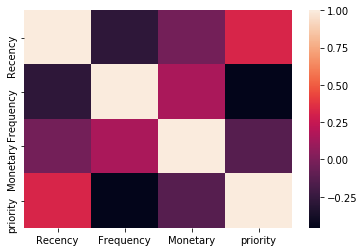

In [41]:
sns.heatmap(rfm.corr())

We can notice that corelation between Monetary and Frequency is a slightly higher bit it is not too strong. Also for recency its too low and is more towards negative value.

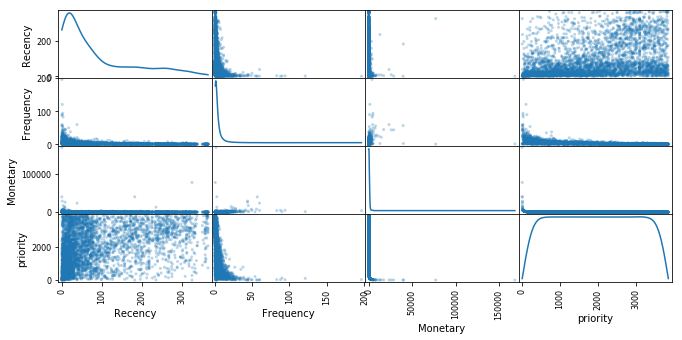

In [42]:
# Produce a scatter matrix for each pair of features in the data
scatter_matrix(rfm, alpha = 0.3, figsize = (11,5), diagonal = 'kde');

We can notice that the distribution is skewed for all three cases. We can normalize the data to overcome this.

**Data Normalization**

In [43]:
#log transformation

# adding small quantity to handle log 0 case which could be 1, this would lead to misinterpretation
r_log = np.log(rfm['Recency']+0.1) 
f_log = np.log(rfm['Frequency'])
m_log = np.log(rfm['Monetary']+0.1)

In [44]:
log_ds = pd.DataFrame({'Recency': r_log, 'Monetary': m_log,'Frequency': f_log})


In [45]:
log_ds.head()

,Recency,Monetary,Frequency
CustomerID,,,
12346.0,5.784133,11.253944,0.000000
12747.0,0.741937,6.490708,2.302585
12748.0,-2.302585,8.226662,5.278115
12749.0,1.131402,4.589549,1.609438
12820.0,1.131402,4.065602,1.386294


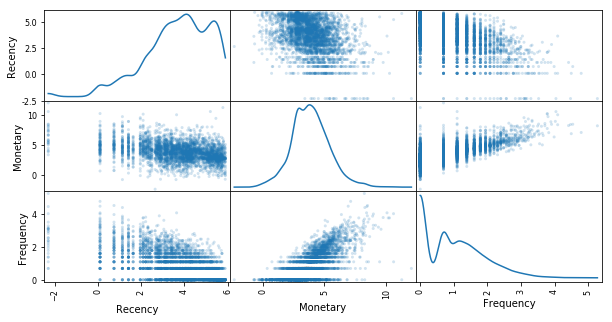

In [46]:
# Produce a scatter matrix for each pair of features in the data
scatter_matrix(log_ds, alpha = 0.2, figsize = (10,5), diagonal = 'kde');

By this we can notice that the distribution is more normalized observing the curve. But for frequency and Recency it is not showing much improvement.

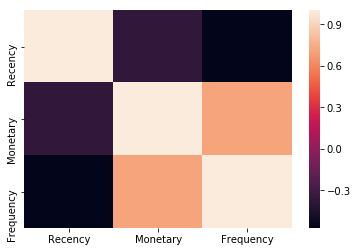

In [47]:
sns.heatmap(log_ds.corr())

We can notice that Corelation between Monetary and Frequency  is strong in this case, but with recency it's still negtive

In [48]:
log_ds.corr()

,Recency,Monetary,Frequency
Recency,1.000000,-0.364351,-0.569951
Monetary,-0.364351,1.000000,0.715609
Frequency,-0.569951,0.715609,1.000000


**K-means Implementation**

**Visualize Clusters for n=2 **

In [63]:
n_clusters = 2
kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
kmeans.fit(matrix)
clusters_gen = kmeans.predict(matrix)
silhouette_avg = silhouette_score(matrix, clusters_gen)
print('score de silhouette: {:<.3f}'.format(silhouette_avg))

score de silhouette: 0.389


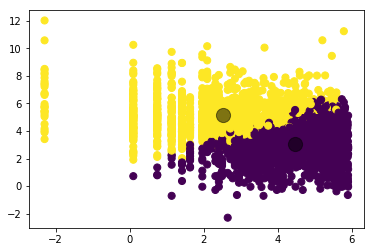

In [64]:
# visualising a scatter plot
plt.scatter(matrix[:, 0], matrix[:, 1], c = clusters_gen, s=50, cmap='viridis')
# centroids for the cluster
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

In [65]:
# total number of customers in each cluster formed by k-means
pd.DataFrame(pd.Series(clusters).value_counts(), columns = ['NumberCustomers']).T

,0,1
NumberCustomers,2337,1526


** Gaussian Mixture Model Implementation**

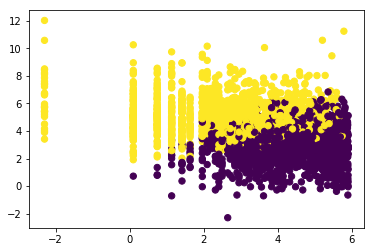

In [66]:
gmm = GMM(n_components=2).fit(matrix)
labels = gmm.predict(matrix)
plt.scatter(matrix[:, 0], matrix[:, 1], c=labels, s=40, cmap='viridis');

In [67]:
# total number of customers in each cluster formed by GMM
pd.DataFrame(pd.Series(labels).value_counts(), columns = ['NumberCustomers']).T

,0,1
NumberCustomers,2226,1637


No improvement seen(No clear boundary of seperation between the clusters).

In this approach we are using Recency, Frequency and Monetary to form cluster of customers using k-means clustering algorithm. We can notice that there is no clear boundary of seperation between the clusters. This could because of the presence of teh outliers. The chances of data points  being  miscalssified  is high because of this reason. 

Drawbacks asociated with this clustering is that:
1. The probablility of a data point being in two clusters is high.
2. This can not be a guaranteed as a global solution.
3. Does not work efficiently for models with limited feature sets.

So we tries workign with Guassian Mixture Model, but the results aren't that great when compared to the kmeans clustering. Guassian Mixture model was used with the intension to explotit it's flexibility to make use of unconstrained covariances. GMM involves probabilistic cluster assignment.